# Summary

In this notebook we train a NN with only one real sequence per batch. 

---

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [2]:
%run _imports.ipynb

Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2017-12-30 16:54:12.871889


In [3]:
%run _settings.ipynb

In [4]:
from typing import NamedTuple
import random
random.seed(42)

import h5py
from sklearn import metrics

In [5]:
import pagnn
importlib.reload(pagnn)

<module 'pagnn' from '/home/kimlab1/strokach/working/pagnn/pagnn/__init__.py'>

In [6]:
NOTEBOOK_NAME = 'train_neural_network'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()
NOTEBOOK_PATH.mkdir(exist_ok=True)

# Parameters

## Gene3D domains

In [7]:
with open(f'generate_datasets/gene3d_domains.pickle', 'rb') as fin:
    GENE3D_DOMAINS = pickle.load(fin)

## Training / validation domains

In [8]:
with open(f'generate_datasets/training_domains.pickle', 'rb') as fin:
    TRAINING_DOMAINS = pickle.load(fin)
    
with open(f'generate_datasets/validation_domains.pickle', 'rb') as fin:
    VALIDATION_DOMAINS = pickle.load(fin)
    
with open(f'generate_datasets/test_domains.pickle', 'rb') as fin:
    TEST_DOMAINS = pickle.load(fin)

## Training / validation parquet files

In [9]:
with open(f'generate_datasets/training_parquet_files.pickle', 'rb') as fin:
    TRAINING_PARQUET_FILES = pickle.load(fin)
    
with open(f'generate_datasets/validation_parquet_files.pickle', 'rb') as fin:
    VALIDATION_PARQUET_FILES = pickle.load(fin)
    
with open(f'generate_datasets/test_parquet_files.pickle', 'rb') as fin:
    TEST_PARQUET_FILES = pickle.load(fin)

# Train

In [16]:
import GPUtil
deviceIDs = GPUtil.getAvailable(order = 'first', limit = 1, maxLoad = 0.5, maxMemory = 0.5)
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in deviceIDs)
os.environ['CUDA_VISIBLE_DEVICES']

'0'

In [49]:
importlib.reload(pagnn.models)

<module 'pagnn.models' from '/home/kimlab1/strokach/working/pagnn/pagnn/models/__init__.py'>

In [50]:
# %% Train network

net = pagnn.models.SingleDomainNet().cuda()

# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()

# create your optimizer
# optimizer = optim.SGD(net.parameters(), lr=0.2, momentum=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.001)

In [51]:
ADJACENCY_MATRIX_PATH = (
    Path('/home/strokach/databin')
    .joinpath('uniparc_domain')
    .joinpath('0.1')
    .joinpath('adjacency_matrix.parquet')
    .absolute()
)
ADJACENCY_MATRIX_PATH

PosixPath('/home/strokach/databin/uniparc_domain/0.1/adjacency_matrix.parquet')

In [52]:
# VALIDATION_HDF5_FILE = Path(f'generate_datasets/validation-unc.h5').absolute()

In [53]:
VALIDATION_HDF5_FILE = Path(f'generate_datasets/validation-gzip-0.h5').absolute()

In [54]:
try:
    assert test_data
except (NameError, AssertionError):
    test_data = []

    with h5py.File(VALIDATION_HDF5_FILE, 'r') as hdf_file:
        for grp in tqdm.tqdm_notebook(hdf_file):
            for subgroup in hdf_file[grp]:
                test_aa = hdf_file[grp][subgroup]['seqs'][:]
                test_adj_expanded = hdf_file[grp][subgroup]['adj'][:]
                test_targets = hdf_file[grp][subgroup]['targets'][:]

                test_data.append((test_aa, test_adj_expanded, test_targets))

In [61]:
# === Run ===
next_domain_performance = []
train_performance = []
validation_performance = []

columns = ['qseq', 'residue_idx_1_corrected', 'residue_idx_2_corrected']

idx = 0
for domain_idx, domain_folder in enumerate(tqdm.tqdm_notebook(TRAINING_DOMAINS, total=len(TRAINING_DOMAINS))):
    domain = domain_folder.partition('A%3A')[-1]
    domain_path = ADJACENCY_MATRIX_PATH.joinpath(domain_folder)
    for row_idx, row in enumerate(tqdm.tqdm_notebook(
            pagnn.iter_domain_rows(domain_path, columns=columns), 
            leave=False,
            desc=f'Domain {domain_idx}',
            smoothing=0.9)):
        row_key = f'/{domain}/{row_idx:05d}'
        try:
            dataset = pagnn.row_to_dataset(row, num_real=8, num_fake=56)
        except pagnn.SequenceTooShortError:
            print('Skipping short sequence...')
            continue
    
        # Generate tensors
        aa = np.array([pagnn.get_seq_array(seq) for seq in dataset.seqs])
        aa = Variable(torch.Tensor(aa)).cuda()
        adj_expanded = Variable(torch.FloatTensor(pagnn.expand_adjacency(dataset.adj).astype(np.float32))).cuda()
        targets = Variable(torch.Tensor(dataset.targets.astype(np.float32)), requires_grad=False).cuda()

        # In the training loop
        optimizer.zero_grad()  # zero the gradient buffers
        output = net(aa, adj_expanded)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()  # Does the update

        if idx % 100 == 0:
            score = metrics.roc_auc_score(targets.cpu().data.numpy().astype(int), output.cpu().data.numpy())
            train_performance.append((idx, score))

        if row_idx == 0:
            score = metrics.roc_auc_score(targets.cpu().data.numpy().astype(int), output.cpu().data.numpy())
            next_domain_performance.append((idx, score))
        
        if row_idx == 0:
            all_test_targets = []
            all_test_predictions = []
#             with h5py.File(VALIDATION_HDF5_FILE.as_posix(), 'r') as hdf5_file:
#                 for grp in tqdm.tqdm_notebook(
#                         hdf5_file, total=len(VALIDATION_DOMAINS), leave=False, desc='Validation'):
#                     for subgrp in list(hdf5_file[grp]):
#                         test_seqs = hdf5_file[grp][subgrp]['seqs'][:]
#                         test_adj = hdf5_file[grp][subgrp]['adj'][:]
#                         test_targets = hdf5_file[grp][subgrp]['targets'][:]

            for test_seqs, test_adj, test_targets in tqdm.tqdm_notebook(
                            test_data, total=len(test_data), leave=False, desc='Validation'):
                        test_aa = np.array([pagnn.get_seq_array(seq) for seq in test_seqs])
                        test_aa = Variable(torch.Tensor(test_aa), requires_grad=False).cuda()
                        test_adj_expanded = Variable(
                            torch.FloatTensor(pagnn.expand_adjacency(test_adj).astype(np.float32)),
                            requires_grad=False).cuda()
                        test_targets = Variable(
                            torch.Tensor(test_targets.astype(np.float32)), requires_grad=False).cuda()

                        predictions = net(test_aa, test_adj_expanded)
                        
                        all_test_targets.append(test_targets.cpu().data.numpy())
                        all_test_predictions.append(predictions.cpu().data.numpy())
                        
            all_test_targets = np.hstack(all_test_targets)
            all_test_predictions = np.hstack(all_test_predictions)
            score = metrics.roc_auc_score(all_test_targets, all_test_predictions)
            validation_performance.append((idx, score))
            print(score)
            
        idx += 1
        
        if row_idx == 1999:
            break

HBox(children=(IntProgress(value=0, max=1029), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='Domain 0', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Validation', max=16555), HTML(value='')))

Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90


0.509252042445
Skipping short sequence...
Skipping short sequence...


HBox(children=(IntProgress(value=1, bar_style='info', description='Domain 1', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Validation', max=16555), HTML(value='')))

Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Exception in thread Thread-12:
Traceback (most recent call last):
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot 

0.755027579376


HBox(children=(IntProgress(value=1, bar_style='info', description='Domain 2', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Validation', max=16555), HTML(value='')))

Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90


0.714719781704


HBox(children=(IntProgress(value=1, bar_style='info', description='Domain 3', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Validation', max=16555), HTML(value='')))

Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90


0.597183629867



KeyboardInterrupt: 

Text(0,0.5,'ROC AUC score')

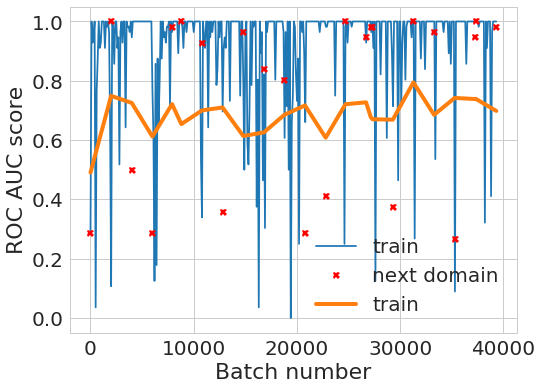

In [17]:
fg, ax = plt.subplots(figsize=(8, 6))

plt.plot(list(zip(*train_performance))[0], list(zip(*train_performance))[1], label='train')
plt.plot(list(zip(*next_domain_performance))[0], list(zip(*next_domain_performance))[1], 'rX', label='next domain')
plt.plot(list(zip(*validation_performance))[0], list(zip(*validation_performance))[1], label='train', linewidth=4)
plt.ylim = (0, 1)
plt.legend()
plt.xlabel('Batch number')
plt.ylabel('ROC AUC score')